# Phylogeographic Temporal Analysis

PTA is what you get when you put a bunch of momi and dadi inference together.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import time

from IPython.display import display

import PTA


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# ipcluster start --n=4 --cluster-id="PTA" --daemonize
ipyclient = ipp.Client(cluster_id="PTA")
len(ipyclient)

4

# Build a demographic model

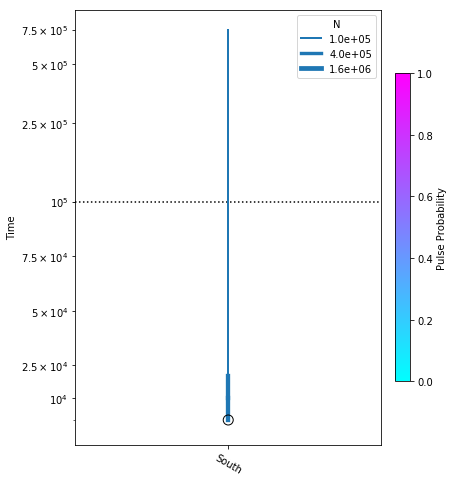

In [33]:
model = momi.DemographicModel(N_e=1e6)
model.add_leaf("South")
#model.add_time_param("texp")
model.set_size("South", t=20000, N=1e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

# Simulate

In [4]:
model = PTA.DemographicModel("watdo")
msfs_list = model.serial_simulate(nsims=2, quiet=False, verbose=False)

  [####################] 100%  Finished 2 simulations in   0:00:00 | 
 

# Look at the results

In [33]:
sim_df = pd.read_csv("../PTA/default_PTA/1000_loci-SIMOUT.csv", sep=" ")
sim_df.head()

,zeta,psi,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,0.842,3,74,146,321,62,142,343,100,170,...,281,36,80,247,51,115,329,78,152,313
1,0.921,4,86,153,301,60,132,318,96,145,...,287,73,145,350,72,143,339,91,131,330
2,0.929,2,75,169,341,104,161,339,85,197,...,292,50,112,316,50,110,297,27,87,229
3,0.446,1,13,47,158,11,39,162,12,41,...,347,121,175,373,119,188,407,102,168,353
4,0.612,2,46,94,325,51,105,265,127,181,...,267,54,90,320,160,187,409,101,204,350


# Some simple plotting routines

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


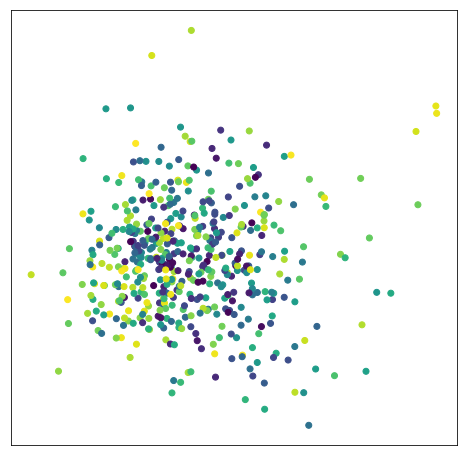

In [34]:
sim_df = pd.read_csv("../PTA/default_PTA/SIMOUT.csv", sep=" ").head(500)
PTA.plotting.plot_simulations_pca(sim_df)

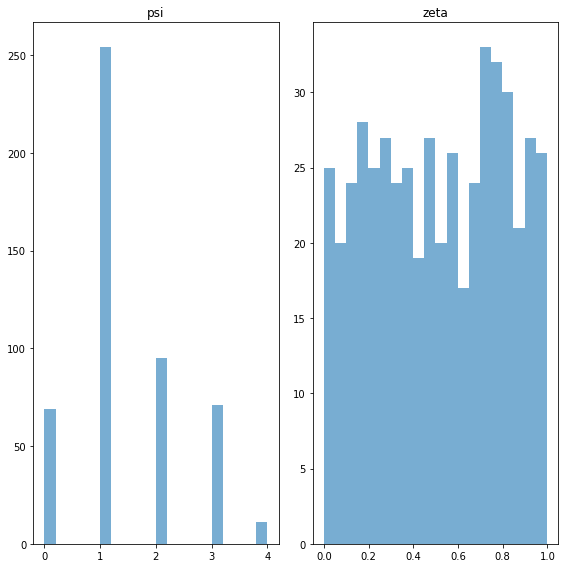

In [25]:
axs = PTA.plotting.plot_simulations_hist(sim_df)

# ML Inference
## Prep the data

In [30]:
## Prep the data
## Just take the first one as the pseudo-observed data
empirical_df = pd.DataFrame(sim_df.loc[0]).T.drop(["zeta", "psi"], axis=1)
display(empirical_df)
tmp_df = sim_df.drop([0])

,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,12.0,23.0,27.0,18.0,19.0,24.0,11.0,22.0,43.0,5.0,...,53.0,11.0,12.0,26.0,15.0,27.0,51.0,12.0,13.0,34.0


# Cross-validation on classification of Psi

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


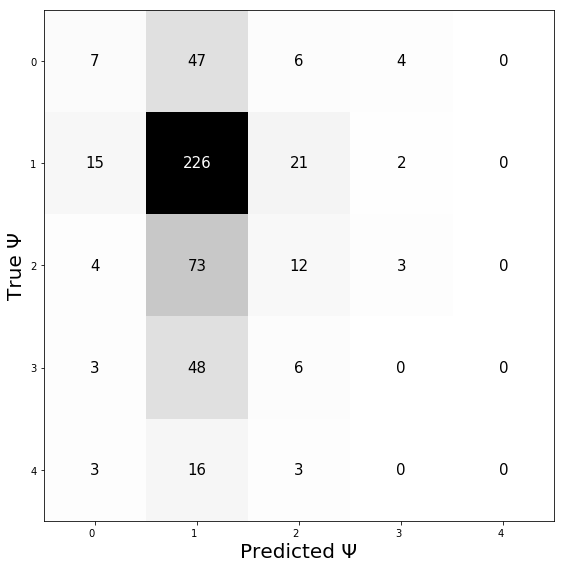

In [35]:
cla = PTA.inference.classification_cv(sim_df)
ax = cla.plot_confusion_matrix()

# Cross-validation on estimation of zeta

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


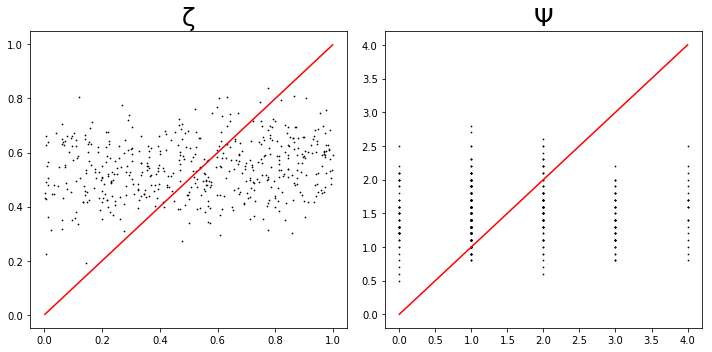

In [36]:
cla = PTA.inference.parameter_estimation_cv(sim_df)
ax = cla.plot_cv_predictions(figdims=(1,2))

# Perform Psi estimation

In [9]:
cla = PTA.inference.Classifier(empirical_df=empirical_df, sims=tmp_df, verbose=False)
est, proba = cla.predict(select_features=False, param_search=False, quick=True, verbose=True)

Predict() started: 2019-09-30 20:15:58.128416
Predict() finished: 2019-09-30 20:15:58.250720


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/isaac/PTA/PTA/inference.py:375: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_model.fit(self.X, self.y)


,psi
estimate,1


,0,1,2,3,4
psi,0.0,0.6,0.3,0.1,0.0


,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
Feature importance,0.028478,0.030191,0.047167,0.043051,0.044182,0.029316,0.039663,0.029832,0.034793,0.032706,...,0.04054,0.025895,0.025345,0.024201,0.02875,0.019867,0.035872,0.01803,0.038007,0.031876


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2505dd668>]],
      dtype=object)

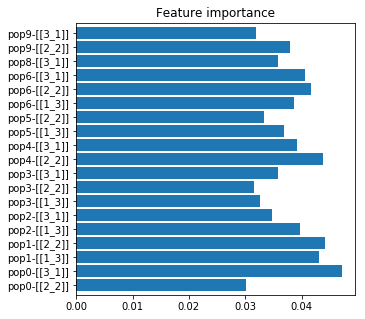

In [10]:
display(est, proba)
display(cla.feature_importances())
cla.plot_feature_importance(figsize=(5,5), cutoff=0.03)

In [12]:
rgr = PTA.inference.Regressor(empirical_df=empirical_df, sims=tmp_df)
est = rgr.predict(select_features=False, param_search=False, quick=True, verbose=False)

In [13]:
display(est)

,zeta,psi
estimate,0.6481,1.4
lower 0.025,0.1180,0.0
upper 0.975,0.9890,3.0


# Trash below here

In [1069]:
## Simulated empirical

def get_sfs(name, N_e=1e6, t=20000, exp_magnitude=10, verbose=False):
    model = momi.DemographicModel(N_e=N_e)
    model.add_leaf(name)
    model.set_size(name, t=t, N=N_e/exp_magnitude)
    sampled_n_dict={name:4}
    if verbose: print(sampled_n_dict)
    ac = model.simulate_data(length=100,
                            num_replicates=100,
                            recoms_per_gen=1e-9,
                            muts_per_gen=1e-8,
                            sampled_n_dict=sampled_n_dict)
    return ac.extract_sfs(n_blocks=1)

south_sfs = get_sfs("South")
north_sfs = get_sfs("North")
central_sfs = get_sfs("Central", exp_magnitude=1)
np.array([south_sfs.loc_counts, central_sfs.loc_counts, north_sfs.loc_counts])

array([[[  9.,  51.,  15.]],

       [[378., 122., 220.]],

       [[ 21.,  54.,  13.]]])

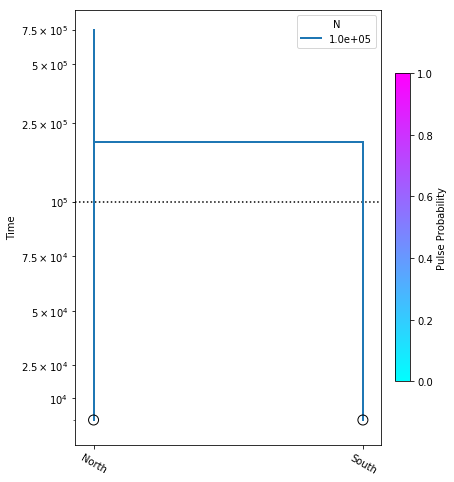

In [3]:
model = momi.DemographicModel(N_e=1e5)
model.add_leaf("North")
model.add_leaf("South")
model.move_lineages("South", "North", t=2e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["North", "South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [13]:
sampled_n_dict={"North":4, "South":4}
ac = model.simulate_data(length=100,
                    num_replicates=1000,
                    recoms_per_gen=1e-9,
                    muts_per_gen=1e-8,
                    sampled_n_dict=sampled_n_dict)

In [43]:
imps = cla.feature_importances()
display(imps)
imps = imps[imps.columns[imps.max() > 0.0]]

,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],pop2-[[3_1]],pop3-[[1_3]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
Feature importance,0.032729,0.034168,0.038152,0.030881,0.036986,0.040976,0.033452,0.034764,0.033924,0.03247,...,0.032149,0.029115,0.030943,0.035424,0.027655,0.030318,0.033001,0.030367,0.030545,0.034648


NameError: name 'cutoff' is not defined